In [113]:
pip install termcolor

Note: you may need to restart the kernel to use updated packages.


In [114]:
pip install yfinance

Note: you may need to restart the kernel to use updated packages.


In [127]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import requests
from math import floor
from termcolor import colored as cl

plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (20,10)

In [128]:
#Short segment
#Financials
xlf = yf.download('XLF', start="2022-11-01", end="2022-12-1", interval = "5m")
kre = yf.download('KRE', start="2022-11-01", end="2022-12-1", interval = "5m")
fas = yf.download('FAS', start="2022-11-01", end="2022-12-1", interval = "5m")

#Industrial/Infotech
soxl = yf.download('SOXL', start="2022-11-01", end="2022-12-1", interval = "5m")
xlk = yf.download('XLK', start="2022-11-01", end="2022-12-1", interval = "5m")
soxx = yf.download('SOXX', start="2022-11-01", end="2022-12-1", interval = "5m")
vgt = yf.download('VGT', start="2022-11-01", end="2022-12-1", interval = "5m")
tecl = yf.download('TECL', start="2022-11-01", end="2022-12-1", interval = "5m")

#----------------------------------------------#-------------------------------------------------#

#Long segment
#Staples/Materials
xlb = yf.download('XLB', start="2022-11-01", end="2022-12-1", interval = "5m")
xme = yf.download('XME', start="2022-11-01", end="2022-12-1", interval = "5m")
vaw = yf.download('VAW', start="2022-11-01", end="2022-12-1", interval = "5m")
#Energy
oih = yf.download('OIH', start="2022-11-01", end="2022-12-1", interval = "5m")
ura = yf.download('URA', start="2022-11-01", end="2022-12-1", interval = "5m")
tan = yf.download('TAN', start="2022-11-01", end="2022-12-1", interval = "5m")


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [129]:
def get_supertrend(high, low, close, lookback, multiplier):
    
    # ATR
    
    tr1 = pd.DataFrame(high - low)
    tr2 = pd.DataFrame(abs(high - close.shift(1)))
    tr3 = pd.DataFrame(abs(low - close.shift(1)))
    frames = [tr1, tr2, tr3]
    tr = pd.concat(frames, axis = 1, join = 'inner').max(axis = 1)
    atr = tr.ewm(lookback).mean()
    
    # H/L AVG AND BASIC UPPER & LOWER BAND
    
    hl_avg = (high + low) / 2
    upper_band = (hl_avg + multiplier * atr).dropna()
    lower_band = (hl_avg - multiplier * atr).dropna()
    
    # FINAL UPPER BAND
    final_bands = pd.DataFrame(columns = ['upper', 'lower'])
    final_bands.iloc[:,0] = [x for x in upper_band - upper_band]
    final_bands.iloc[:,1] = final_bands.iloc[:,0]
    for i in range(len(final_bands)):
        if i == 0:
            final_bands.iloc[i,0] = 0
        else:
            if (upper_band[i] < final_bands.iloc[i-1,0]) | (close[i-1] > final_bands.iloc[i-1,0]):
                final_bands.iloc[i,0] = upper_band[i]
            else:
                final_bands.iloc[i,0] = final_bands.iloc[i-1,0]
    
    # FINAL LOWER BAND
    
    for i in range(len(final_bands)):
        if i == 0:
            final_bands.iloc[i, 1] = 0
        else:
            if (lower_band[i] > final_bands.iloc[i-1,1]) | (close[i-1] < final_bands.iloc[i-1,1]):
                final_bands.iloc[i,1] = lower_band[i]
            else:
                final_bands.iloc[i,1] = final_bands.iloc[i-1,1]
    
    # SUPERTREND
    
    supertrend = pd.DataFrame(columns = [f'supertrend_{lookback}'])
    supertrend.iloc[:,0] = [x for x in final_bands['upper'] - final_bands['upper']]
    
    for i in range(len(supertrend)):
        if i == 0:
            supertrend.iloc[i, 0] = 0
        elif supertrend.iloc[i-1, 0] == final_bands.iloc[i-1, 0] and close[i] < final_bands.iloc[i, 0]:
            supertrend.iloc[i, 0] = final_bands.iloc[i, 0]
        elif supertrend.iloc[i-1, 0] == final_bands.iloc[i-1, 0] and close[i] > final_bands.iloc[i, 0]:
            supertrend.iloc[i, 0] = final_bands.iloc[i, 1]
        elif supertrend.iloc[i-1, 0] == final_bands.iloc[i-1, 1] and close[i] > final_bands.iloc[i, 1]:
            supertrend.iloc[i, 0] = final_bands.iloc[i, 1]
        elif supertrend.iloc[i-1, 0] == final_bands.iloc[i-1, 1] and close[i] < final_bands.iloc[i, 1]:
            supertrend.iloc[i, 0] = final_bands.iloc[i, 0]
    
    supertrend = supertrend.set_index(upper_band.index)
    supertrend = supertrend.dropna()[1:]
    
    # ST UPTREND/DOWNTREND
    
    upt = []
    dt = []
    close = close.iloc[len(close) - len(supertrend):]

    for i in range(len(supertrend)):
        if close[i] > supertrend.iloc[i, 0]:
            upt.append(supertrend.iloc[i, 0])
            dt.append(np.nan)
        elif close[i] < supertrend.iloc[i, 0]:
            upt.append(np.nan)
            dt.append(supertrend.iloc[i, 0])
        else:
            upt.append(np.nan)
            dt.append(np.nan)
            
    st, upt, dt = pd.Series(supertrend.iloc[:, 0]), pd.Series(upt), pd.Series(dt)
    upt.index, dt.index = supertrend.index, supertrend.index
    
    return st, upt, dt

In [130]:
#short etf
xlf['st'], xlf['s_upt'], xlf['st_dt'] = get_supertrend(xlf['High'], xlf['Low'], xlf['Close'], 10, 3)
xlf = xlf[1:]
print(xlf.head())

#buy soxl
soxl['st'], soxl['s_upt'], soxl['st_dt'] = get_supertrend(soxl['High'], soxl['Low'], soxl['Close'], 10, 3)
soxl = soxl[1:]
print(soxl.head())

                          Open       High        Low      Close  Adj Close  \
Datetime                                                                     
2022-11-01 09:35:00  34.279999  34.309700  34.200001  34.259998  34.259998   
2022-11-01 09:40:00  34.255001  34.345001  34.255001  34.308899  34.308899   
2022-11-01 09:45:00  34.305000  34.310001  34.200001  34.259998  34.259998   
2022-11-01 09:50:00  34.259998  34.279900  34.220001  34.259998  34.259998   
2022-11-01 09:55:00  34.255001  34.287800  34.240002  34.244999  34.244999   

                      Volume         st  s_upt      st_dt  
Datetime                                                   
2022-11-01 09:35:00   729926  34.534379    NaN  34.534379  
2022-11-01 09:40:00  1327159  34.534379    NaN  34.534379  
2022-11-01 09:45:00   991004  34.534379    NaN  34.534379  
2022-11-01 09:50:00   524249  34.514653    NaN  34.514653  
2022-11-01 09:55:00   226877  34.503282    NaN  34.503282  
                       Open  High

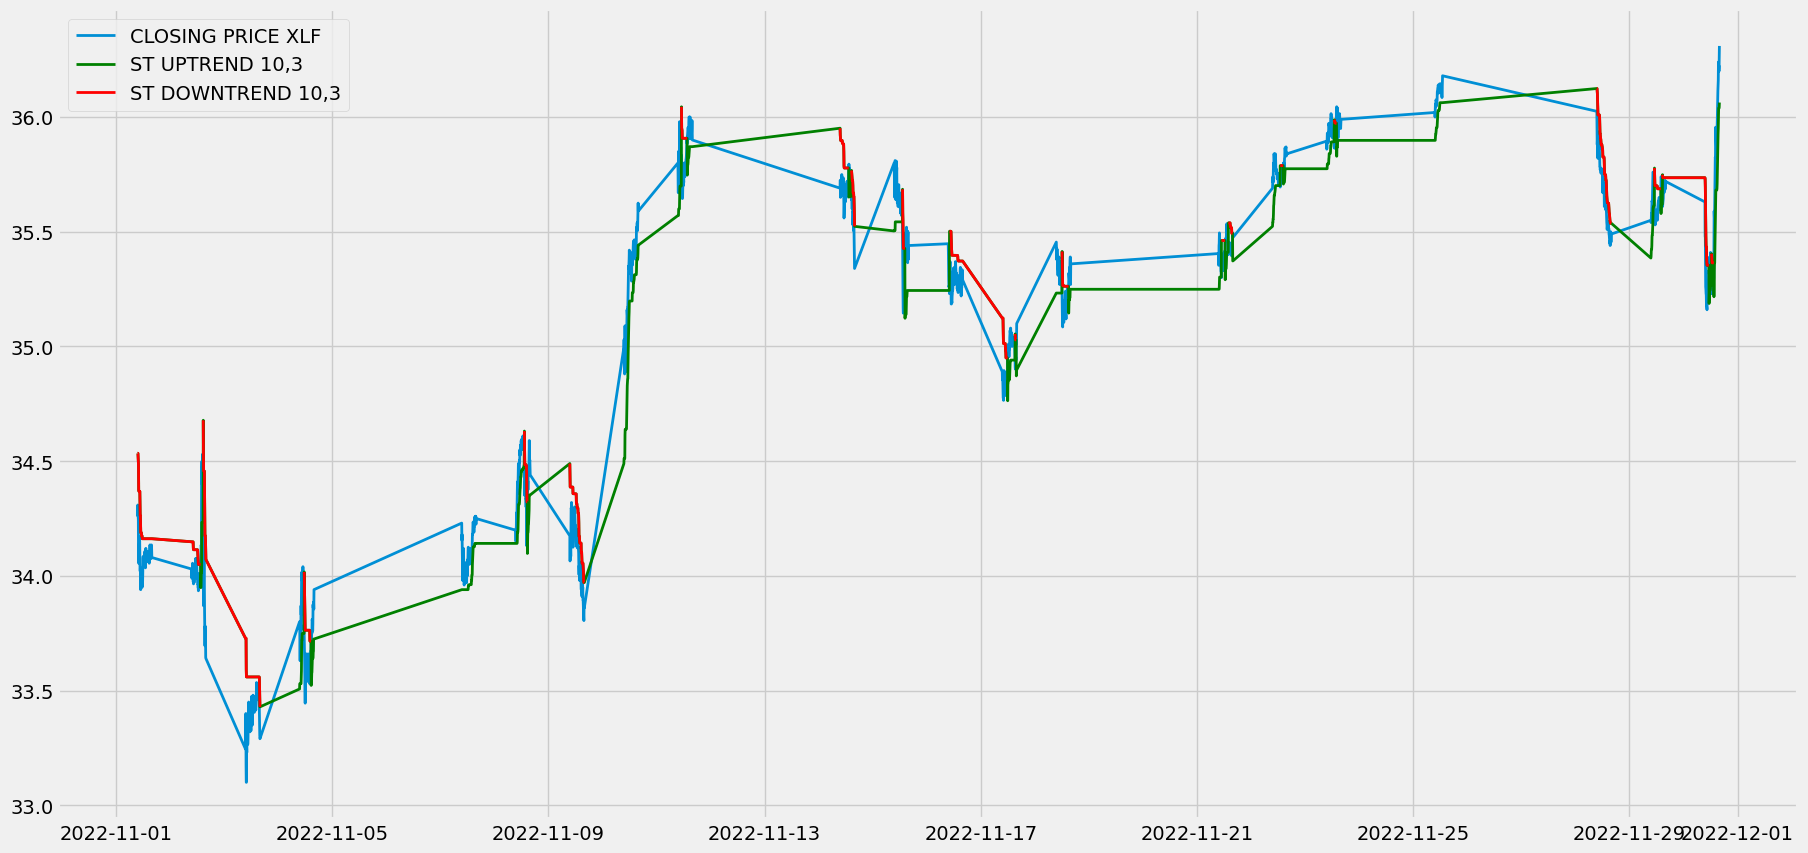

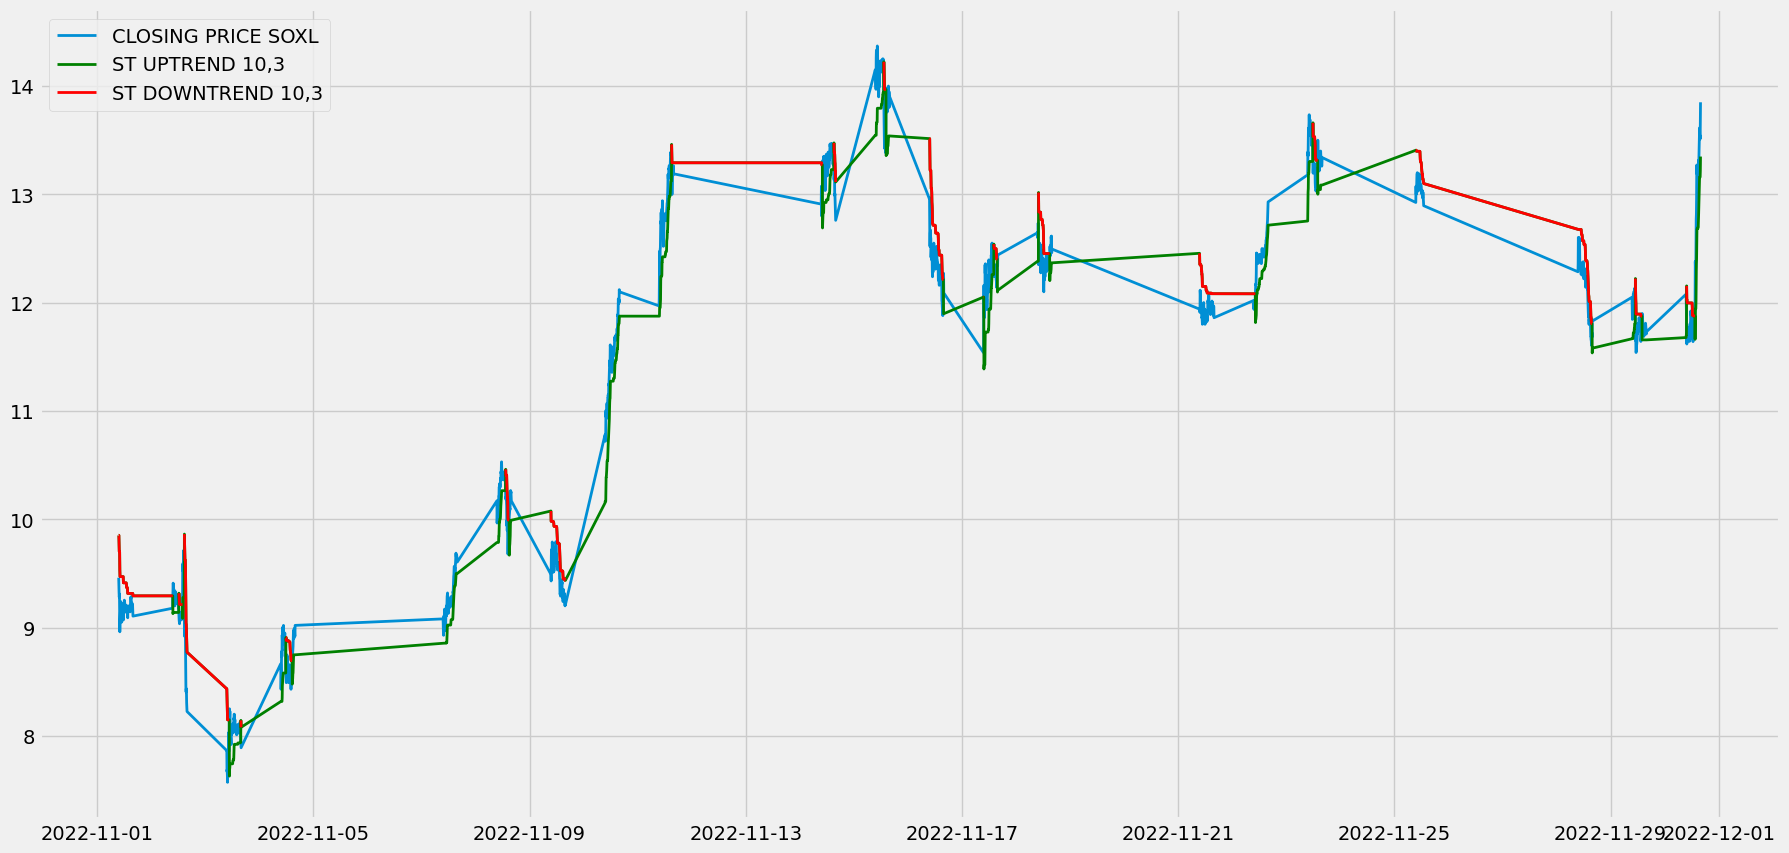

In [189]:
# SUPERTREND PLOT

plt.plot(xlf['Close'], linewidth = 2, label = 'CLOSING PRICE XLF')
plt.plot(xlf['st'], color = 'green', linewidth = 2, label = 'ST UPTREND 10,3')
plt.plot(xlf['st_dt'], color = 'r', linewidth = 2, label = 'ST DOWNTREND 10,3')
plt.legend(loc = 'upper left')
plt.show()

plt.plot(soxl['Close'], linewidth = 2, label = 'CLOSING PRICE SOXL')
plt.plot(soxl['st'], color = 'green', linewidth = 2, label = 'ST UPTREND 10,3')
plt.plot(soxl['st_dt'], color = 'r', linewidth = 2, label = 'ST DOWNTREND 10,3')
plt.legend(loc = 'upper left')
plt.show()

In [233]:
def sma(data, window=5):
    sma = data.rolling(window = window).mean()
    return sma

In [234]:
def bb(data, sma, window=5):
    std = data.rolling(window = window).std()
    upper_bb = sma + std 
    lower_bb = sma - std
    return upper_bb, lower_bb

In [235]:
sma_signal = sma(xlf['Close'])

In [236]:
upper_bb,lower_bb = bb(xlf['Close'], sma_signal)

In [237]:
def implement_bb_strategy(data, lower_bb, upper_bb):
    buy_price = []
    sell_price = []
    bb_signal = []
    signal = 0
    
    for i in range(len(data)):
        if data[i-1] > lower_bb[i-1] and data[i] < lower_bb[i]:
            if signal != 1:
                buy_price.append(data[i])
                sell_price.append(np.nan)
                signal = 1
                bb_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                bb_signal.append(0)
        elif data[i-1] < upper_bb[i-1] and data[i] > upper_bb[i]:
            if signal != -1:
                buy_price.append(np.nan)
                sell_price.append(data[i])
                signal = -1
                bb_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                bb_signal.append(0)
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            bb_signal.append(0)
            
    return bb_signal

In [238]:
bb_signal = implement_bb_strategy(xlf['Close'], upper_bb,lower_bb)

In [248]:
midband = (upper_bb + lower_bb)/2

In [249]:
def mid_band(data, midband):
    buy_price = []
    sell_price = []
    bb_signal = []
    signal = 0
    
    for i in range(len(data)):
        if data[i-1] < midband[i] and data[i] > midband[i]:
            if signal != 1:
                buy_price.append(data[i])
                sell_price.append(np.nan)
                signal = 1
                bb_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                bb_signal.append(0)
        elif data[i-1] > midband[i] and data[i] < midband[i]:
            if signal != -1:
                buy_price.append(np.nan)
                sell_price.append(data[i])
                signal = -1
                bb_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                bb_signal.append(0)
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            bb_signal.append(0)
            
    return bb_signal

In [250]:
midsignal = mid_band(xlf['Close'],midband)

In [251]:
midsignal

[0,
 0,
 0,
 0,
 0,
 -1,
 0,
 0,
 0,
 1,
 0,
 0,
 -1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 -1,
 1,
 0,
 -1,
 0,
 1,
 -1,
 1,
 0,
 0,
 0,
 -1,
 0,
 1,
 -1,
 1,
 0,
 0,
 -1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 -1,
 1,
 0,
 0,
 -1,
 0,
 0,
 1,
 0,
 0,
 -1,
 0,
 0,
 1,
 0,
 0,
 -1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 -1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 -1,
 0,
 0,
 0,
 1,
 0,
 -1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 -1,
 0,
 1,
 -1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 -1,
 0,
 1,
 0,
 -1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 -1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 -1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 -1,
 0,
 1,
 0,
 0,
 0,
 -1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 -1,
 0,
 1,
 -1,
 1,
 0,
 0,
 -1,
 0,
 0,
 1,
 0,
 0,
 0,
 -1,
 0,
 0,
 1,
 -1,
 0,
 0,
 1,
 0,
 0,
 0,
 -1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 -1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 -1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 -1,
 0,
 1,
 0,
 0,
 0,


In [259]:
# TRADING STRATEGY

def implement_st_strategy(bb_signal,prices, st):
    buy_price = []
    sell_price = []
    st_signal = []
    signal = 0
    
    for i in range(len(st)):
        if st[i-1] > prices[i-1] and st[i] < prices[i] or midsignal[i]==1:
            if signal != 1:
                buy_price.append(prices[i])
                sell_price.append(np.nan)
                signal = 1
                st_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                st_signal.append(0)
        elif st[i-1] < prices[i-1] and st[i] > prices[i] or midsignal[i]==-1:
            if signal != -1:
                buy_price.append(np.nan)
                sell_price.append(prices[i])
                signal = -1
                st_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                st_signal.append(0)
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            st_signal.append(0)
            
    return buy_price, sell_price, st_signal

In [260]:
buy_price, sell_price, st_signal = implement_st_strategy(bb_signal,xlf['Close'], soxl['st'])

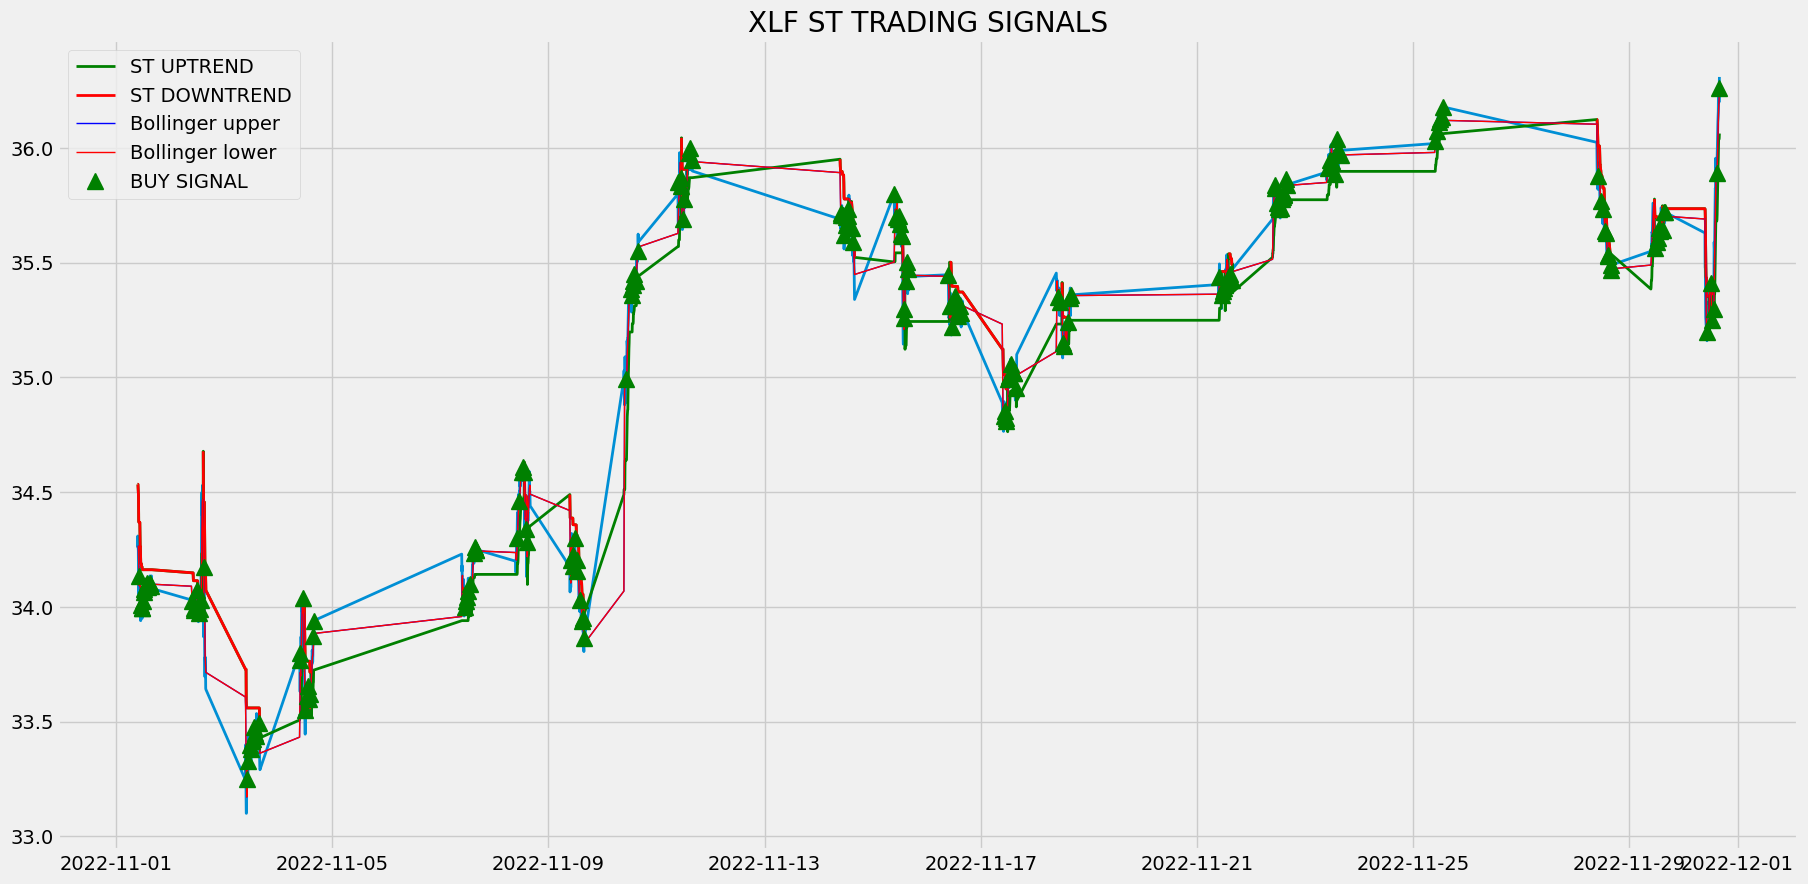

In [261]:
plt.plot(xlf['Close'], linewidth = 2)
plt.plot(xlf['st'], color = 'green', linewidth = 2, label = 'ST UPTREND')
plt.plot(xlf['st_dt'], color = 'r', linewidth = 2, label = 'ST DOWNTREND')
plt.plot(upper_bb,color="blue",linewidth = 1, label = 'Bollinger upper')
plt.plot(lower_bb,color="red",linewidth = 1, label = 'Bollinger lower')

plt.plot(xlf.index, buy_price, marker = '^', color = 'green', markersize = 12, linewidth = 0, label = 'BUY SIGNAL')
#plt.plot(xlf.index, sell_price, marker = 'v', color = 'r', markersize = 12, linewidth = 0, label = 'SELL SIGNAL')
plt.title('XLF ST TRADING SIGNALS')
plt.legend(loc = 'upper left')
plt.show()

In [262]:
# GENERATING STOCK POSITION XLF
position = []
for i in range(len(st_signal)):
    if st_signal[i] > 1:
        position.append(0)
    else:
        position.append(1)
        
for i in range(len(xlf['Close'])):
    if st_signal[i] == 1:
        position[i] = 1
    elif st_signal[i] == -1:
        position[i] = 0
    else:
        position[i] = position[i-1]
        
close_price = xlf['Close']
st = xlf['st']
st_signal = pd.DataFrame(st_signal).rename(columns = {0:'st_signal'}).set_index(xlf.index)
position = pd.DataFrame(position).rename(columns = {0:'st_position'}).set_index(xlf.index)

frames = [close_price, st, st_signal, position]
strategy_xlf = pd.concat(frames, join = 'inner', axis = 1)

strategy_xlf.head()

,Close,st,st_signal,st_position
Datetime,,,,
2022-11-01 09:35:00,34.259998,34.534379,0,1
2022-11-01 09:40:00,34.308899,34.534379,0,1
2022-11-01 09:45:00,34.259998,34.534379,0,1
2022-11-01 09:50:00,34.259998,34.514653,0,1
2022-11-01 09:55:00,34.244999,34.503282,0,1


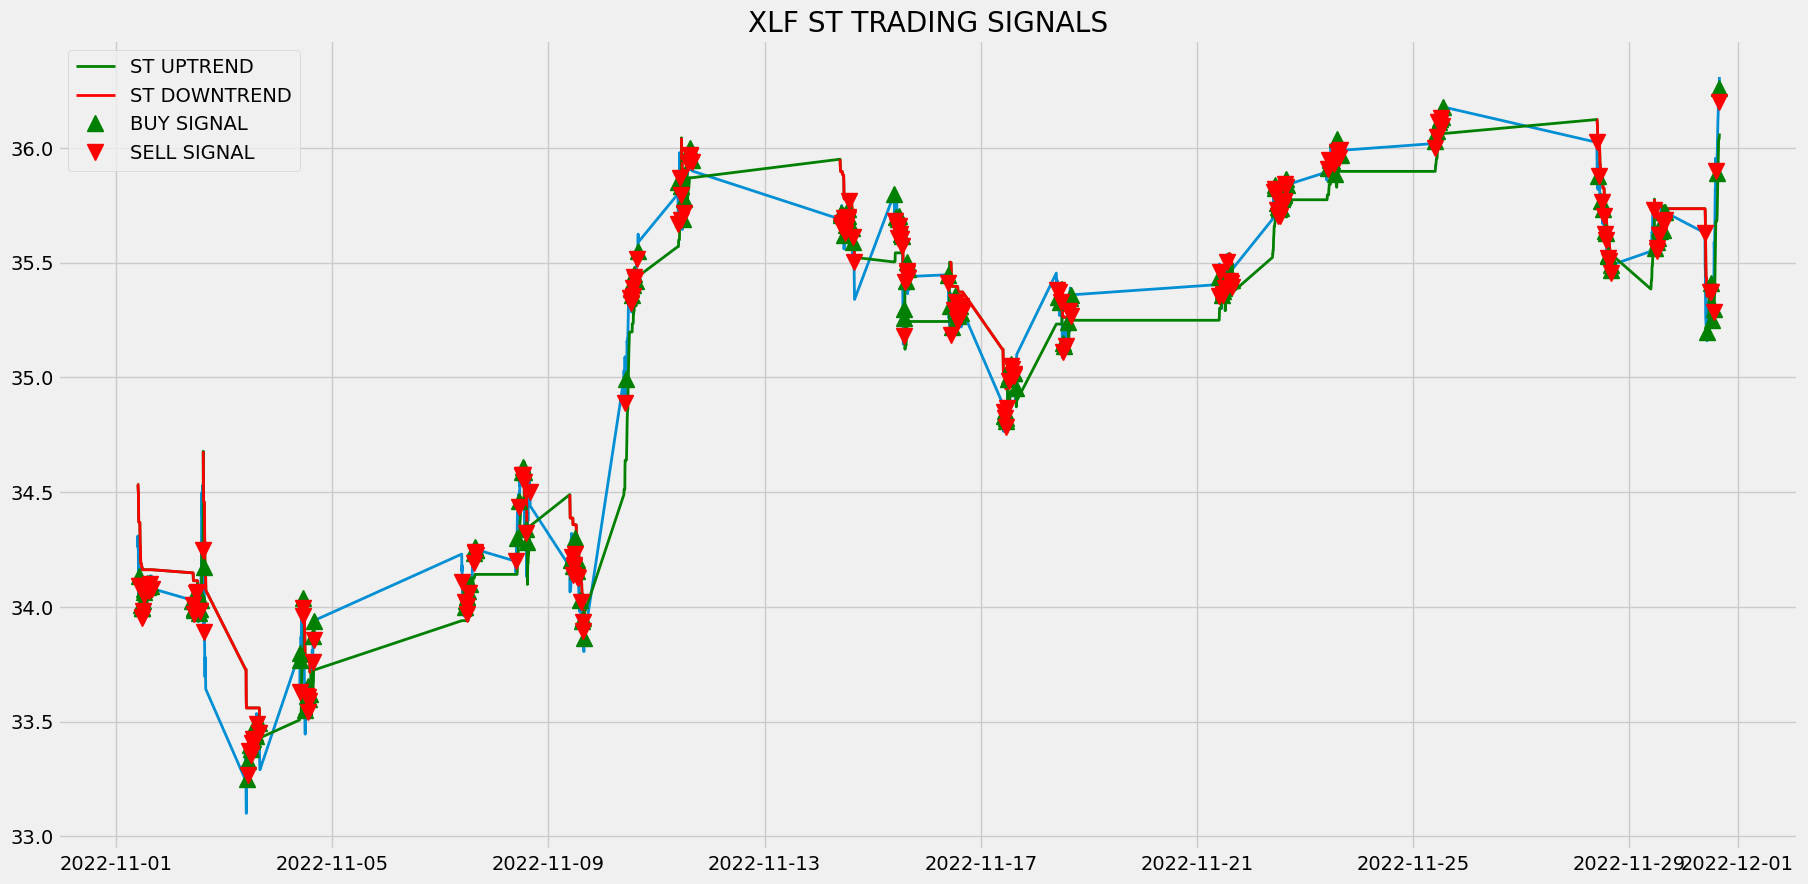

In [265]:
# SUPERTREND SIGNALS

plt.plot(xlf['Close'], linewidth = 2)
plt.plot(xlf['st'], color = 'green', linewidth = 2, label = 'ST UPTREND')
plt.plot(xlf['st_dt'], color = 'r', linewidth = 2, label = 'ST DOWNTREND')
plt.plot(xlf.index, buy_price, marker = '^', color = 'green', markersize = 12, linewidth = 0, label = 'BUY SIGNAL')
plt.plot(xlf.index, sell_price, marker = 'v', color = 'r', markersize = 12, linewidth = 0, label = 'SELL SIGNAL')
plt.title('XLF ST TRADING SIGNALS')
plt.legend(loc = 'upper left')
plt.show()

In [266]:
buy_price, sell_price, st_signal = implement_st_strategy(soxl['Close'], soxl['st'])

TypeError: implement_st_strategy() missing 1 required positional argument: 'st'

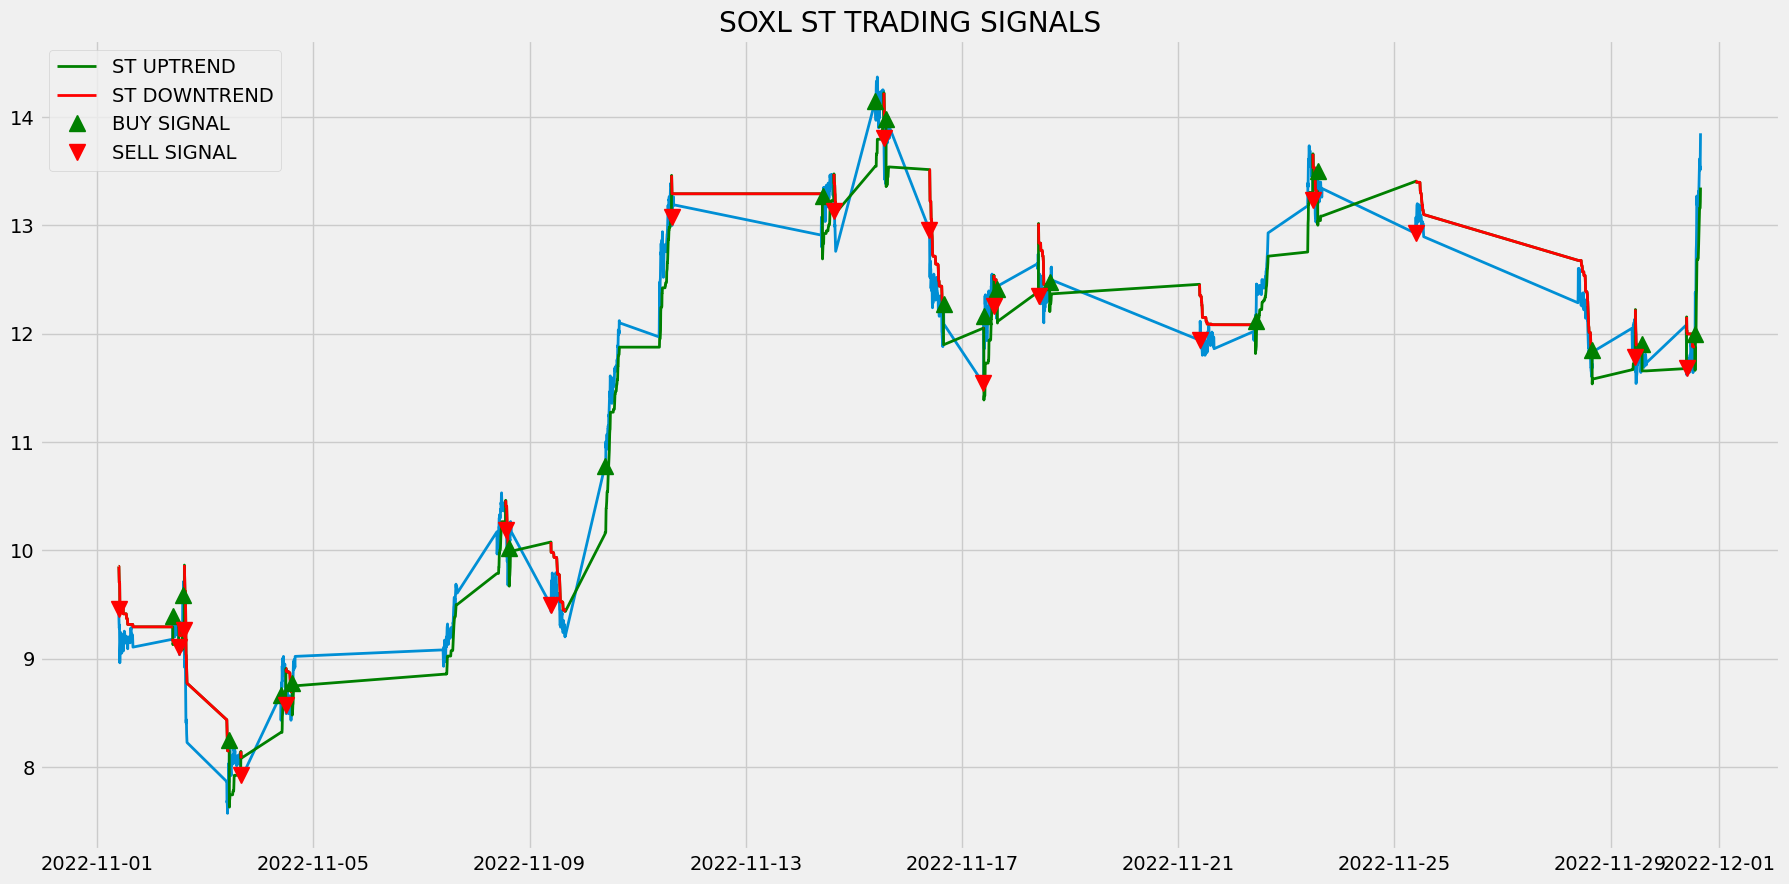

In [154]:
plt.plot(soxl['Close'], linewidth = 2)
plt.plot(soxl['st'], color = 'green', linewidth = 2, label = 'ST UPTREND')
plt.plot(soxl['st_dt'], color = 'r', linewidth = 2, label = 'ST DOWNTREND')
plt.plot(soxl.index, buy_price, marker = '^', color = 'green', markersize = 12, linewidth = 0, label = 'BUY SIGNAL')
plt.plot(soxl.index, sell_price, marker = 'v', color = 'r', markersize = 12, linewidth = 0, label = 'SELL SIGNAL')
plt.title('SOXL ST TRADING SIGNALS')
plt.legend(loc = 'upper left')
plt.show()

In [155]:
# GENERATING STOCK POSITION SOXL
position = []
for i in range(len(st_signal)):
    if st_signal[i] > 1:
        position.append(0)
    else:
        position.append(1)
        
for i in range(len(soxl['Close'])):
    if st_signal[i] == 1:
        position[i] = 1
    elif st_signal[i] == -1:
        position[i] = 0
    else:
        position[i] = position[i-1]
        
close_price = soxl['Close']
st = soxl['st']
st_signal = pd.DataFrame(st_signal).rename(columns = {0:'st_signal'}).set_index(soxl.index)
position = pd.DataFrame(position).rename(columns = {0:'st_position'}).set_index(soxl.index)

frames = [close_price, st, st_signal, position]
strategy_soxl = pd.concat(frames, join = 'inner', axis = 1)

strategy_soxl.head()

,Close,st,st_signal,st_position
Datetime,,,,
2022-11-01 09:35:00,9.4600,9.852002,-1,0
2022-11-01 09:40:00,9.3750,9.852002,0,0
2022-11-01 09:45:00,9.3201,9.759623,0,0
2022-11-01 09:50:00,9.2800,9.700912,0,0
2022-11-01 09:55:00,9.3100,9.700912,0,0


In [263]:
# BACKTESTING
xlf_ret = pd.DataFrame(np.diff(xlf['Close'])).rename(columns = {0:'returns'})
st_strategy_ret = []

for i in range(len(xlf_ret)):
    returns = xlf_ret['returns'][i]*strategy['st_position'][i]
    st_strategy_ret.append(returns)
    
st_strategy_ret_df = pd.DataFrame(st_strategy_ret).rename(columns = {0:'st_returns'})
investment_value = 100000
number_of_stocks = floor(investment_value/xlf['Close'][-1])
st_investment_ret = []

for i in range(len(st_strategy_ret_df['st_returns'])):
    returns = number_of_stocks*st_strategy_ret_df['st_returns'][i]
    st_investment_ret.append(returns)

st_investment_ret_df = pd.DataFrame(st_investment_ret).rename(columns = {0:'investment_returns'})
total_investment_ret = round(sum(st_investment_ret_df['investment_returns']), 2)
profit_percentage = floor((total_investment_ret/investment_value)*100)
print(cl('Profit gained from the ST strategy by investing $100k in xlf : {}'.format(total_investment_ret), attrs = ['bold']))
print(cl('Profit percentage of the ST strategy : {}%'.format(profit_percentage), attrs = ['bold']))

Profit gained from the ST strategy by investing $100k in xlf : 2535.88
Profit percentage of the ST strategy : 2%


In [264]:
# SPY ETF COMPARISON XLF
def get_benchmark(start_date, investment_value):
    spy = yf.download('SPY', start_date)['Close']
    benchmark = pd.DataFrame(np.diff(spy)).rename(columns = {0:'benchmark_returns'})
    
    investment_value = investment_value
    number_of_stocks = floor(investment_value/spy[-1])
    benchmark_investment_ret = []
    
    for i in range(len(benchmark['benchmark_returns'])):
        returns = number_of_stocks*benchmark['benchmark_returns'][i]
        benchmark_investment_ret.append(returns)

    benchmark_investment_ret_df = pd.DataFrame(benchmark_investment_ret).rename(columns = {0:'investment_returns'})
    return benchmark_investment_ret_df

benchmark = get_benchmark('2022-01-01', 100000)
investment_value = 100000
total_benchmark_investment_ret = round(sum(benchmark['investment_returns']), 2)
benchmark_profit_percentage = floor((total_benchmark_investment_ret/investment_value)*100)
print(cl('Benchmark profit by investing $100k : {}'.format(total_benchmark_investment_ret), attrs = ['bold']))
print(cl('Benchmark Profit percentage : {}%'.format(benchmark_profit_percentage), attrs = ['bold']))
print(cl('ST Strategy profit is {}% higher than the Benchmark Profit'.format(profit_percentage - benchmark_profit_percentage), attrs = ['bold']))

[*********************100%***********************]  1 of 1 completed
Benchmark profit by investing $100k : -21221.64
Benchmark Profit percentage : -22%
ST Strategy profit is 24% higher than the Benchmark Profit


In [161]:
# BACKTESTING
soxl_ret = pd.DataFrame(np.diff(soxl['Close'])).rename(columns = {0:'returns'})
st_strategy_ret = []

for i in range(len(soxl_ret)):
    returns = soxl_ret['returns'][i]*strategy['st_position'][i]
    st_strategy_ret.append(returns)
    
st_strategy_ret_df = pd.DataFrame(st_strategy_ret).rename(columns = {0:'st_returns'})
investment_value = 100000
number_of_stocks = floor(investment_value/soxl['Close'][-1])
st_investment_ret = []

for i in range(len(st_strategy_ret_df['st_returns'])):
    returns = number_of_stocks*st_strategy_ret_df['st_returns'][i]
    st_investment_ret.append(returns)

st_investment_ret_df = pd.DataFrame(st_investment_ret).rename(columns = {0:'investment_returns'})
total_investment_ret = round(sum(st_investment_ret_df['investment_returns']), 2)
profit_percentage = floor((total_investment_ret/investment_value)*100)
print(cl('Profit gained from the ST strategy by investing $100k in xlf : {}'.format(total_investment_ret), attrs = ['bold']))
print(cl('Profit percentage of the ST strategy : {}%'.format(profit_percentage), attrs = ['bold']))

Profit gained from the ST strategy by investing $100k in xlf : 10923.16
Profit percentage of the ST strategy : 10%


In [162]:
# SPY ETF COMPARISON SOXL
def get_benchmark(start_date, investment_value):
    spy = yf.download('SPY', start_date)['Close']
    benchmark = pd.DataFrame(np.diff(spy)).rename(columns = {0:'benchmark_returns'})
    
    investment_value = investment_value
    number_of_stocks = floor(investment_value/spy[-1])
    benchmark_investment_ret = []
    
    for i in range(len(benchmark['benchmark_returns'])):
        returns = number_of_stocks*benchmark['benchmark_returns'][i]
        benchmark_investment_ret.append(returns)

    benchmark_investment_ret_df = pd.DataFrame(benchmark_investment_ret).rename(columns = {0:'investment_returns'})
    return benchmark_investment_ret_df

benchmark = get_benchmark('2022-01-01', 100000)
investment_value = 100000
total_benchmark_investment_ret = round(sum(benchmark['investment_returns']), 2)
benchmark_profit_percentage = floor((total_benchmark_investment_ret/investment_value)*100)
print(cl('Benchmark profit by investing $100k : {}'.format(total_benchmark_investment_ret), attrs = ['bold']))
print(cl('Benchmark Profit percentage : {}%'.format(benchmark_profit_percentage), attrs = ['bold']))
print(cl('ST Strategy profit is {}% higher than the Benchmark Profit'.format(profit_percentage - benchmark_profit_percentage), attrs = ['bold']))

[*********************100%***********************]  1 of 1 completed
Benchmark profit by investing $100k : -21221.64
Benchmark Profit percentage : -22%
ST Strategy profit is 32% higher than the Benchmark Profit
